# Tensor Multiplication Speed-Up for Measurement Errors

I use the _kronecker product_ to speed up the huge matrix multiplication that is adding bitflip measurement errors to the quantum computing output measurement.

Error rates are found either according to either calibration data, or processed from experiments.

In [1]:
# Create path to src directory
# use specified path if running on e.g. a HPC system 
import sys
sys.path.insert(1, '../src')

from MeasureMatrix import fast_interaction_multiply
import numpy as np
import json

# Read in a json file containing calibration data N
with open("../data/qubit_data.json", 'r') as file:
    data = json.load(file)
qubit_props = data['oneQubitProperties']
num_qubits = len(qubit_props)

# Initialise the error rate arrays
epsilon01 = np.zeros(num_qubits)
epsilon10 = np.zeros(num_qubits)

# Place in the error rates!
for qub_ind,qub in enumerate(qubit_props):
    e01 = qubit_props[qub]['oneQubitFidelity'][1]['fidelity']
    e10 = qubit_props[qub]['oneQubitFidelity'][2]['fidelity']
    epsilon01[qub_ind] = e01
    epsilon10[qub_ind] = e10

In [2]:
first = np.zeros(2**num_qubits)
first[0] = 1
huge_count_list = fast_interaction_multiply(first,num_qubits,epsilon01,epsilon10)
print("\n" + str(huge_count_list[0:100])) # If you want to see 0.01% of the huge list of the bitstring counts
print("\n" + str(sum(huge_count_list))) # All the count rates add to one, up to numerical error, which is good, since it should be conserved
print("\n" + str(huge_count_list[::10000])) # Every 10,000th bitstring, getting smaller (roughly) as we need more bitflips to achieve it 


[0.6043839148889287, 0.007960477095801492, 0.009203815962775563, 0.00012122553952997195, 0.013595548187685514, 0.00017907003691986997, 0.00020703880488861186, 2.7269548769523345e-06, 0.020948640609186872, 0.00027591927854045525, 0.0003190148316119828, 4.201816424473937e-06, 0.000471237314317087, 6.206773136901855e-06, 7.176202756097772e-06, 9.451938787160185e-08, 0.04479322247834166, 0.0005899816537167594, 0.00068213029154835, 8.984492188580092e-06, 0.0010076185015577878, 1.327157094250379e-05, 1.5344444186159202e-05, 2.0210514125640289e-07, 0.0015525845349451063, 2.0449441696338786e-05, 2.3643419313884867e-05, 3.114128177107429e-07, 3.492521448751773e-05, 4.600078909196864e-07, 5.318560581855491e-07, 7.0051963084216195e-09, 0.009203815962775563, 0.00012122553952997195, 0.00014015963395089688, 1.8460742060401818e-06, 0.0002070388048886118, 2.7269548769523337e-06, 3.1528752013494185e-06, 4.1527231628715747e-08, 0.0003190148316119828, 4.201816424473937e-06, 4.858093882415981e-06, 6.3987

## Find the Qubit connectivity in a way which Qiskit will like!

In [3]:
Garnet_Connectivity = []

for i in data['twoQubitProperties']:
    stringy_list = i.split("-")
    floaty_list = [int(item)-1 for item in stringy_list]
    Garnet_Connectivity.append(floaty_list)
    Garnet_Connectivity.append(floaty_list[::-1])

Make a circuit

In [4]:
from qiskit import QuantumCircuit

def get_test_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    
    # 1. Create Superposition on the first qubit
    # (Tests single-qubit 'r' gate noise)
    qc.h(0)
    
    # 2. Entangle neighbors linearly (Chain)
    # (Tests two-qubit 'cx' crosstalk/ZZ noise)
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        
    # 3. Measurement (Optional, depending on if your simulator needs it)
    qc.measure_all()
    
    return qc

# Generate and print
qc = get_test_circuit(num_qubits)
# qc.draw("mpl")

## How to use both qiskit and mqt to compile/transpile circuits

Transpilation is everything: providing native gates and qubit mapping with SABRE. Compilation just efficiently maps the logical qubits to physical qubits, and provides SWAPS when needed.

We will likely use qiskits `transpile()` for our project, as you can change the SABRE heuristic (the circuit cost function) quite well to suite the bitflip errors we intend to find. MQTs `compile()` is good to find exactly optimal mappings, using an A* algorithm, but we need qiskits flexible heuristic system, written in python/rust.

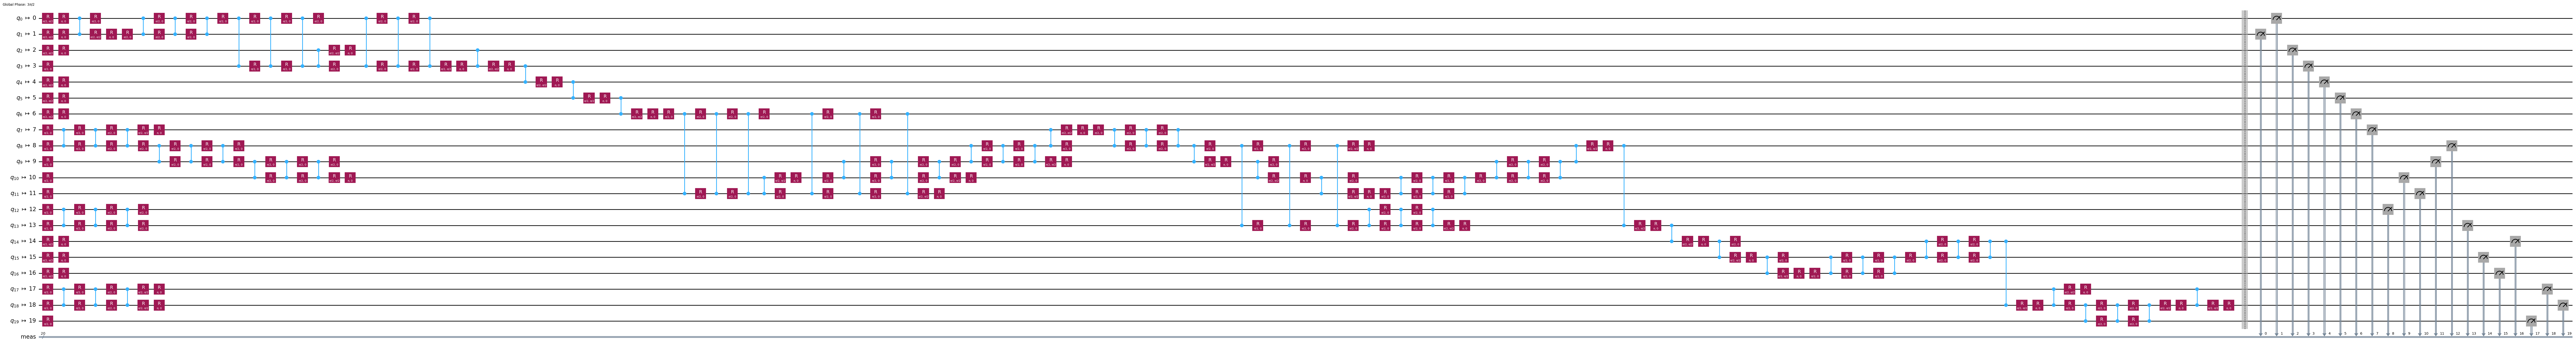

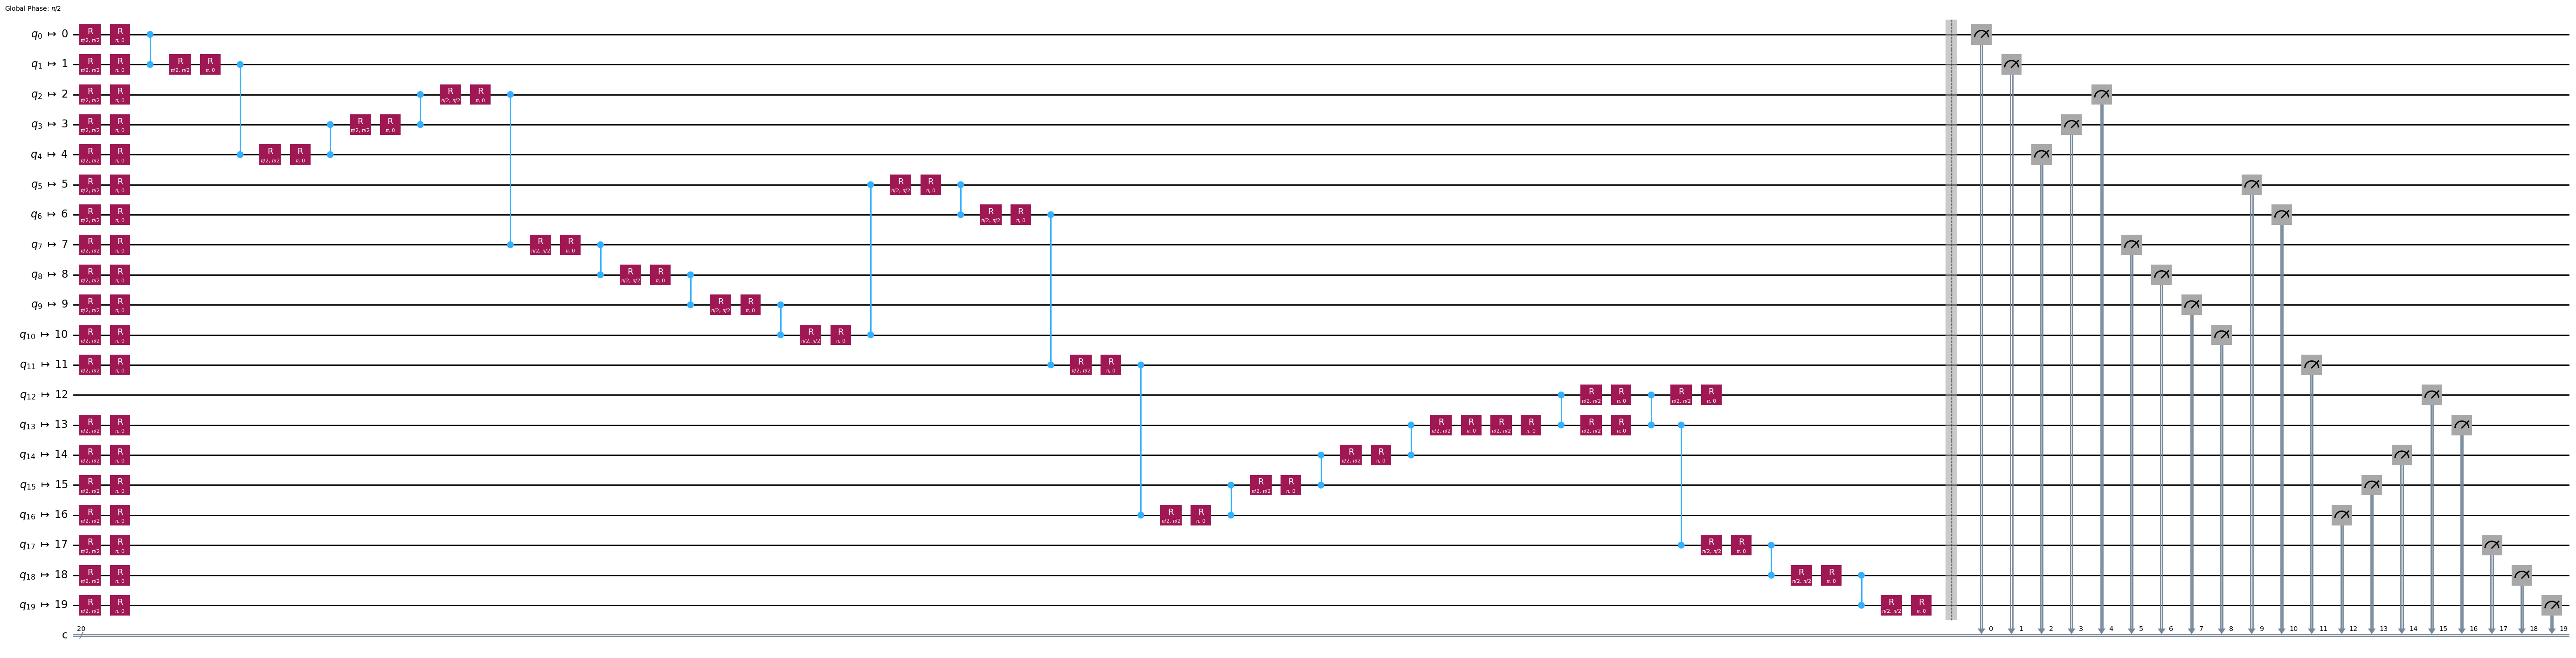

In [5]:
from mqt.qmap.plugins.qiskit.sc import compile
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from mqt.qmap.sc import Method

backend = GenericBackendV2(
    num_qubits = num_qubits,
    basis_gates = ['r', 'rz', 'cz'],
    coupling_map = Garnet_Connectivity
)

# compile circuit to the target architecture

optimization_level = 0
circ_comp = transpile(qc, backend=backend, optimization_level=0)
display(circ_comp.draw(output="mpl", fold=-1))

circ_mapped, results = compile(qc, backend, method = Method.heuristic, post_mapping_optimizations = True)
circ_mapped = transpile(circ_mapped, backend=backend, optimization_level=0)
display(circ_mapped.draw(output="mpl",fold=-1))